The  notebook uses the following file for training:  
Source -https://www.kaggle.com/crowdflower/twitter-airline-sentiment
Description
This data originally came from Crowdflower's Data for Everyone library.

As the original source says,

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

The data on Kaggle is a slightly reformatted version of the original source.

MetaData
The following 15 fields in the .csv file

Field Name	Description  
tweet_id	Twittterr tweet id  
airline_sentiment	Values of 'postive','negetive' and 'neutral'  
airline_sentiment_confidence	Confidence level of the sentiment  
negativereason	Reason for negetive sentiment  
negativereason_confidence	Confidence level for Negetive sentiment reason  
airline	name of the airline  
airline_sentiment_gold	all values Nan. Purpose of the field unclear  
name	twitter person name  
negativereason_gold	all values NaN . Purpose of the field unclear  
retweet_count	count of tweeets for the tweet  
text	tweet text  
tweet_coord	coordinates for the tweet  
tweet_created	tweet created time  
tweet_location	tweet location  
user_timezone	tweet timezone  

In [ ]:
 ! pip install tensorflow tensorflow-text==2.8.* 
 ! pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 5.3 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 578.0 MB 15 kB/s 
     |████████████████████████████████| 636 kB 54.6 MB/s 
     |████████████████████████████████| 99 kB 9.5 MB/s 
     |████████████████████████████████| 1.3 MB 53.7 MB/s 
     |████████████████████████████████| 238 kB 67.0 MB/s 
     |████████████████████████████████| 38.2 MB 81.5 MB/s 
     |████████████████████████████████| 5.9 MB 63.1 MB/s 
     |████████████████████████████████| 352 kB 63.1 MB/s 
     |████████████████████████████████| 1.1 MB 59.0 MB/s 
     |████████████████████████████████| 116 kB 66.1 MB/s 
     |████████████████████████████████| 5.9 MB 42.1 M

Import packages


In [ ]:
import pandas as pd
import numpy as np
import re
import os
import shutil
import tensorflow as tf
from tensorflow import keras
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_text as tf_text
import tensorflow_hub as hub
from official.nlp import optimization
import csv
from tensorflow.keras import callbacks 
from scipy.stats import logistic



In [ ]:
BATCH_SIZE=32
MAX_LENGTH=512
BUFFER_SIZE=50000

## Define source csv location

Tip: If the input files/folders change from the google drive, disconnect and reconnect the run time 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_file_path= "/content/drive/MyDrive/Colab Notebooks/Airline_Tweets.csv"
input_sentiment_train_dir="/content/drive/MyDrive/Colab Notebooks/sentiment_v2/train"
input_pos_sentiment_dir="/content/drive/MyDrive/Colab Notebooks/sentiment_v2/train/pos"
input_neg_sentiment_dir="/content/drive/MyDrive/Colab Notebooks/sentiment_v2/train/neg"
input_neu_sentiment_dir="/content/drive/MyDrive/Colab Notebooks/sentiment_v2/train/neu"
model_save_dir="/content/drive/MyDrive/Colab Notebooks/sentiment_v2/sentiment_model"
model_save_v3="/content/drive/MyDrive/Colab Notebooks/sentiment_v3/sentiment_model"

In [ ]:
os.path.isdir(input_pos_sentiment_dir)

True

In [ ]:
tweet_df=pd.read_csv(input_file_path)

In [ ]:
tweet_df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [ ]:
tweet_df.columns[1]

'airline_sentiment'

In [ ]:
tweet_df.columns[10]

'text'

In [ ]:

tweet_df[['airline_sentiment','text']].groupby(['airline_sentiment'])['text'].agg('count')


airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: text, dtype: int64

## Use the tensorflow hub for Bert model/pre-process


In [ ]:
tfhub_handle_encoder='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model=hub.KerasLayer(tfhub_handle_encoder)

## Read data from directory files


In [ ]:
#split into train,validation, test datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

The subdirectories for the multiple labels are expected to have one tweet or feedback per file. If there are not adequate files( like if we placed 2 files in positive labelled subdirectory- the text_dataset_from_directory throws an error. In the case where we used 10 files one for each tweet, 80% were used for training and 20% for validation

Rules:

1) Name the subdirectories by class ('pos' for positive and 'neg' for negetive for example)  
2) Move the text files ( one per input) into the class based subdirectories  
3) If the number of files are <=2 per class, when creating the validation split paramter- say using a 20-80% split on validation-training, the api throws an error that ' text file could not be found in the directory'

Convert each line of the airline sentiment is created as a separate file in a directory based on the label. Here input file is of the following format-
Sample Line  of the .csv file:

570306133677760513,neutral,1.0,,,Virgin America,,cairdin,,0,@VirginAmerica What @dhepburn said.,,2015-02-24 11:35:52 -0800,,Eastern Time (US & Canada)

The seond field is the label( value of "negetive" or "postive" or "neutral"
The tweet text is field 10. There are a total of 14,640 tweets in the dataset, out of which there are 9178 negative(63 %),3099 neutral tweets(21%),2363(16%)positive tweets.


In [ ]:
# convert every line of input into separate files for upto 100,000 positive and negetive tweets
def split_line_to_file():
	neg_counter=0
	neu_counter = 0
	pos_counter = 0
	with open(input_file_path,"r") as inpf:
		csv_reader=csv.reader(inpf,delimiter=',',quotechar='"')
	
		for line in csv_reader:
				if line[1]=='negative':
					neg_file=os.path.join(input_neg_sentiment_dir,'neg_text_'+str(neg_counter)+'.txt')
					with open(neg_file,'w') as negf:
						negf.write(line[10] + '\n')
					neg_counter+=1
				elif line[1]=='positive':
					pos_file = os.path.join(input_pos_sentiment_dir, 'pos_text_' + str(pos_counter) + '.txt')
					with open(pos_file,'w') as posf:
						posf.write(line[10] + '\n')
					pos_counter+=1
				elif line[1]=='neutral':
					pos_file = os.path.join(input_neu_sentiment_dir, 'neu_text_' + str(neu_counter) + '.txt')
					with open(pos_file,'w') as neuf:
						neuf.write(line[10] + '\n')
					neu_counter+=1
	print(f"postive counter{pos_counter}")
	print(f"negative counter{neg_counter}")
	print(f"neutral counter{neu_counter}")
					

In [ ]:
# call function to split input file lines into separate files
#split_line_to_file()


In [ ]:
import os
neutral_count=len([file for file in os.listdir(input_neu_sentiment_dir)])
positive_count=len([file for file in os.listdir(input_pos_sentiment_dir)])
negetive_count=len([file for file in os.listdir(input_neg_sentiment_dir)])
print(f'neutral_count :{neutral_count}')
print(f'positive_count :{positive_count}')
print(f'negetive_count :{negetive_count}')

neutral_count :3099
positive_count :2363
negetive_count :9178


The time to train n epochs depends on the number of  samples used. When a 20,000 training/test set( 10,000 for postive and 10000 for negetive) was used, the training set used was 20,000*0.8=16000. The batch size used was 32, so the number of steps was 16,000/32=500. The approximate time per step was 10 seconds as the total time taken per epoch  was 5000 seconds(1.3 hours)
The binary accuracy was 83.5 with 3 epochs. To improve the accuracy sample set was increased to 24,000( 12,000 postive+12000 negetive labelled samples), the the number of epochs was increased to 5

In [ ]:
# train dataset creation
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    input_sentiment_train_dir,
    label_mode='categorical',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
    )

Found 14640 files belonging to 3 classes.
Using 11712 files for training.


In [ ]:
raw_train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
class_names=raw_train_ds.class_names
class_names

['neg', 'neu', 'pos']

In [ ]:
#cache and prefetch
train_ds=raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# validation dataset creation
val_ds = tf.keras.utils.text_dataset_from_directory(
    input_sentiment_train_dir,
    label_mode='categorical',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
    )

Found 14640 files belonging to 3 classes.
Using 2928 files for validation.


In [ ]:
#cache and prefetch
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
a = tf.keras.utils.to_categorical([0, 1, 2], num_classes=3)
a

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

## Model creation (trainable BERT)

The bert preprocessing and encoder layer are added as layers to a keras model. The BERT layers are trainable, using a low learning rate

In [ ]:
def create_model(num_classes:int):
  '''
  train the model by updating the BERT layer weights
  '''
  text_input_layer=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
  preprocessing_layer=hub.KerasLayer(tfhub_handle_preprocess,name='preprocessing')
  bert_inputs=preprocessing_layer(text_input_layer)
  bert_model=hub.KerasLayer(tfhub_handle_encoder,trainable=True,name='bert_model')
  bert_output=bert_model(bert_inputs)

  bert_pooled_output = bert_output['pooled_output']
  drop = tf.keras.layers.Dropout(0.1)(bert_pooled_output)
  output=tf.keras.layers.Dense(num_classes,activation='softmax',name="classifier")(drop )
  model = tf.keras.Model(inputs=text_input_layer,outputs=output)
  return model

When the output has 3 dense layers- then the y values used for train and test need to be one hot encoded when using Categorical Cross entropy.
The sparse Categorical Cross entropy oupputs the index of the output class, instead of a one hot encoding of the output probabilities.
Hence the label mode of categorical was used and the keras layer output was made to match the label count.

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.CategoricalAccuracy()

The cardinality is the total training samples/ batch size

In [ ]:
tf.data.experimental.cardinality(train_ds).numpy()

366

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
model=create_model(len(class_names))

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
#Specify callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy',mode='max',patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save_dir,monitor='categorical_accuracy',mode='max',save_best_only=True)
]

# Train the model

When using accuracy vs Categorical Accuracy, the first epoch has a very low accuracy. On replacing the accuracy with CategoricalAccuracy, the value started at over 57%.

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train_ds,validation_data=val_ds,epochs=epochs,callbacks=callbacks)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
366/366 [==============================] - ETA: 0s - loss: 0.7613 - categorical_accuracy: 0.6820

366/366 [==============================] - 572s 2s/step - loss: 0.7613 - categorical_accuracy: 0.6820 - val_loss: 0.5520 - val_categorical_accuracy: 0.7797
Epoch 2/10
366/366 [==============================] - ETA: 0s - loss: 0.4741 - categorical_accuracy: 0.8145

366/366 [==============================] - 561s 2s/step - loss: 0.4741 - categorical_accuracy: 0.8145 - val_loss: 0.4620 - val_categorical_accuracy: 0.8204
Epoch 3/10
366/366 [==============================] - ETA: 0s - loss: 0.3777 - categorical_accuracy: 0.8560

366/366 [==============================] - 540s 1s/step - loss: 0.3777 - categorical_accuracy: 0.8560 - val_loss: 0.4816 - val_categorical_accuracy: 0.8289
Epoch 4/10
366/366 [==============================] - ETA: 0s - loss: 0.3037 - categorical_accuracy: 0.8881

366/366 [==============================] - 540s 1s/step - loss: 0.3037 - categorical_accuracy: 0.8881 - val_loss: 0.5020 - val_categorical_accuracy: 0.8292
Epoch 5/10
366/366 [==============================] - ETA: 0s - loss: 0.2431 - categorical_accuracy: 0.9133

366/366 [==============================] - 525s 1s/step - loss: 0.2431 - categorical_accuracy: 0.9133 - val_loss: 0.5456 - val_categorical_accuracy: 0.8279
Epoch 6/10
366/366 [==============================] - ETA: 0s - loss: 0.1973 - categorical_accuracy: 0.9307

366/366 [==============================] - 525s 1s/step - loss: 0.1973 - categorical_accuracy: 0.9307 - val_loss: 0.5847 - val_categorical_accuracy: 0.8169
Epoch 7/10
366/366 [==============================] - ETA: 0s - loss: 0.1577 - categorical_accuracy: 0.9471

366/366 [==============================] - 527s 1s/step - loss: 0.1577 - categorical_accuracy: 0.9471 - val_loss: 0.6250 - val_categorical_accuracy: 0.8241
Epoch 8/10
366/366 [==============================] - ETA: 0s - loss: 0.1263 - categorical_accuracy: 0.9588

366/366 [==============================] - 534s 1s/step - loss: 0.1263 - categorical_accuracy: 0.9588 - val_loss: 0.6793 - val_categorical_accuracy: 0.8234
Epoch 9/10
366/366 [==============================] - 575s 2s/step - loss: 0.1193 - categorical_accuracy: 0.9575 - val_loss: 0.7013 - val_categorical_accuracy: 0.8251
Epoch 10/10
366/366 [==============================] - ETA: 0s - loss: 0.1047 - categorical_accuracy: 0.9648

366/366 [==============================] - 613s 2s/step - loss: 0.1047 - categorical_accuracy: 0.9648 - val_loss: 0.7171 - val_categorical_accuracy: 0.8268


## plot the loss by epoch

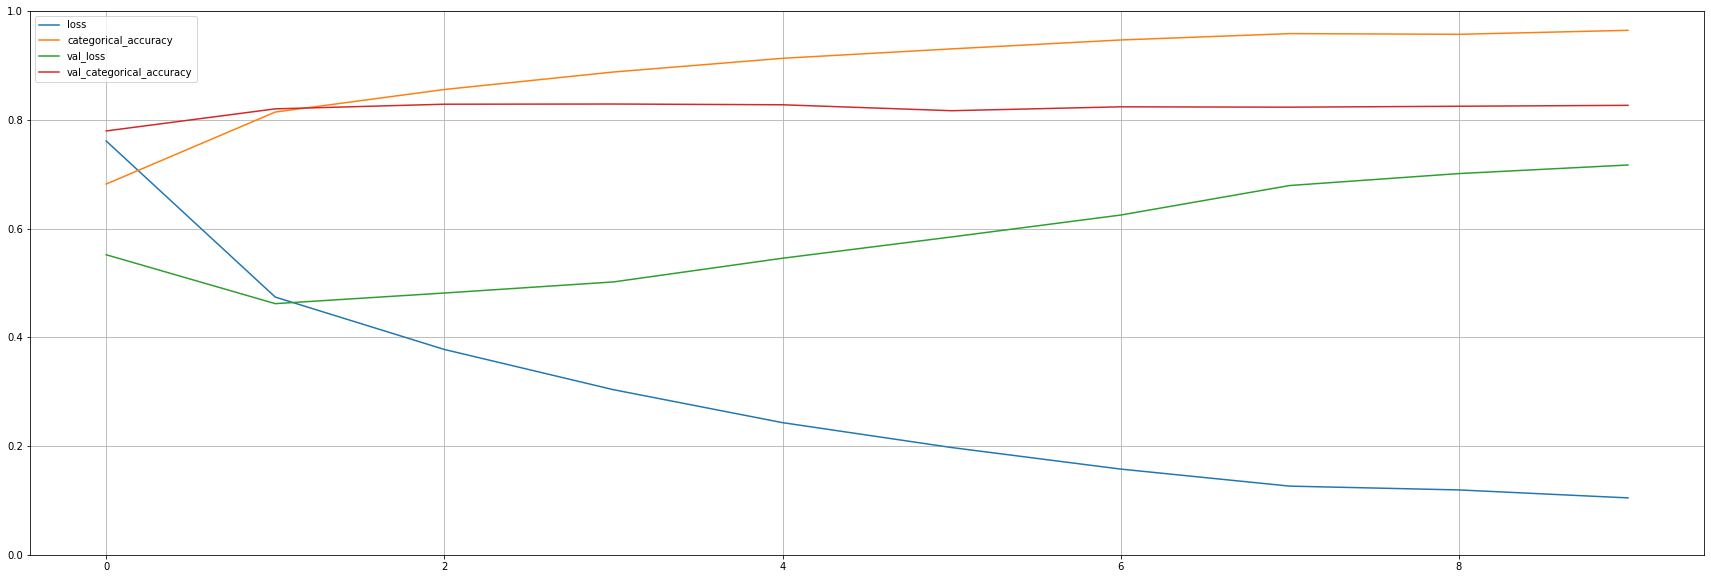

In [ ]:
pd.DataFrame(history.history).plot(figsize=(30,10))
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
#model_saved=tf.keras.models.load_model(model_save_dir,custom_objects={'AdamWeightDecay': optimizer})
model_saved=tf.keras.models.load_model(model_save_dir,compile=False)

In [ ]:
model_saved.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
output=model_saved.predict(['amazing day'])
if np.argmax(output)==2:
  print('Positive')
elif np.argmax(output):
  print('Neutral')
else:
  print('Negetive')

1/1 [==============================] - 0s 98ms/step
Positive


In [ ]:
output=model_saved.predict(['horrible day'])
if np.argmax(output)==2:
  print('Positive')
elif np.argmax(output):
  print('Neutral')
else:
  print('Negetive')

1/1 [==============================] - 0s 110ms/step
Negetive


In [ ]:
output=model_saved.predict(['Middle seat on a red eye'])
if np.argmax(output)==2:
  print('Positive')
elif np.argmax(output):
  print('Neutral')
else:
  print('Negetive')

1/1 [==============================] - 0s 142ms/step
Neutral


In [ ]:
serving_results = model_saved.signatures['serving_default'](tf.constant(['silent day']))
output=np.argmax(serving_results['classifier'])
if output==2:
  print('Positive')
elif output:
  print('Neutral')
else:
  print('Negetive')


Negetive


## Model creation - Freeze BERT weights

In [ ]:
def create_model_v3(num_classes:int):
  '''
  train the model by updating the BERT layer weights
  '''
  text_input_layer=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
  preprocessing_layer=hub.KerasLayer(tfhub_handle_preprocess,name='preprocessing')
  bert_inputs=preprocessing_layer(text_input_layer)
  bert_model=hub.KerasLayer(tfhub_handle_encoder,trainable=False,name='bert_model')
  bert_output=bert_model(bert_inputs)

  bert_pooled_output = bert_output['pooled_output']
  drop = tf.keras.layers.Dropout(0.1)(bert_pooled_output)
  output=tf.keras.layers.Dense(num_classes,activation='softmax',name="classifier")(drop )
  model = tf.keras.Model(inputs=text_input_layer,outputs=output)
  return model

In [ ]:
init_lr = 0.01
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
model=create_model_v3(len(class_names))

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
#Specify callbacks
callbacks_v3 = [
    tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy',mode='max',patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save_v3,monitor='categorical_accuracy',mode='max',save_best_only=True)
]

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train_ds,validation_data=val_ds,epochs=epochs,callbacks=callbacks_v3)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
366/366 [==============================] - ETA: 0s - loss: 0.7518 - categorical_accuracy: 0.7125

366/366 [==============================] - 289s 779ms/step - loss: 0.7518 - categorical_accuracy: 0.7125 - val_loss: 0.7100 - val_categorical_accuracy: 0.7165
Epoch 2/10
366/366 [==============================] - ETA: 0s - loss: 0.6669 - categorical_accuracy: 0.7276

366/366 [==============================] - 264s 723ms/step - loss: 0.6669 - categorical_accuracy: 0.7276 - val_loss: 0.6933 - val_categorical_accuracy: 0.7217
Epoch 3/10
366/366 [==============================] - ETA: 0s - loss: 0.6702 - categorical_accuracy: 0.7294

366/366 [==============================] - 264s 723ms/step - loss: 0.6702 - categorical_accuracy: 0.7294 - val_loss: 0.6089 - val_categorical_accuracy: 0.7466
Epoch 4/10
366/366 [==============================] - ETA: 0s - loss: 0.6480 - categorical_accuracy: 0.7379

366/366 [==============================] - 240s 656ms/step - loss: 0.6480 - categorical_accuracy: 0.7379 - val_loss: 0.5970 - val_categorical_accuracy: 0.7524
Epoch 5/10
366/366 [==============================] - ETA: 0s - loss: 0.6347 - categorical_accuracy: 0.7422

366/366 [==============================] - 226s 617ms/step - loss: 0.6347 - categorical_accuracy: 0.7422 - val_loss: 0.5921 - val_categorical_accuracy: 0.7507
Epoch 6/10
366/366 [==============================] - ETA: 0s - loss: 0.6128 - categorical_accuracy: 0.7509

366/366 [==============================] - 219s 599ms/step - loss: 0.6128 - categorical_accuracy: 0.7509 - val_loss: 0.6215 - val_categorical_accuracy: 0.7418
Epoch 7/10
366/366 [==============================] - 211s 576ms/step - loss: 0.6066 - categorical_accuracy: 0.7491 - val_loss: 0.5894 - val_categorical_accuracy: 0.7561
Epoch 8/10
366/366 [==============================] - ETA: 0s - loss: 0.5869 - categorical_accuracy: 0.7595

366/366 [==============================] - 218s 597ms/step - loss: 0.5869 - categorical_accuracy: 0.7595 - val_loss: 0.5676 - val_categorical_accuracy: 0.7702
Epoch 9/10
366/366 [==============================] - ETA: 0s - loss: 0.5744 - categorical_accuracy: 0.7681

366/366 [==============================] - 199s 544ms/step - loss: 0.5744 - categorical_accuracy: 0.7681 - val_loss: 0.5583 - val_categorical_accuracy: 0.7712
Epoch 10/10
366/366 [==============================] - ETA: 0s - loss: 0.5571 - categorical_accuracy: 0.7732

366/366 [==============================] - 196s 535ms/step - loss: 0.5571 - categorical_accuracy: 0.7732 - val_loss: 0.5518 - val_categorical_accuracy: 0.7688


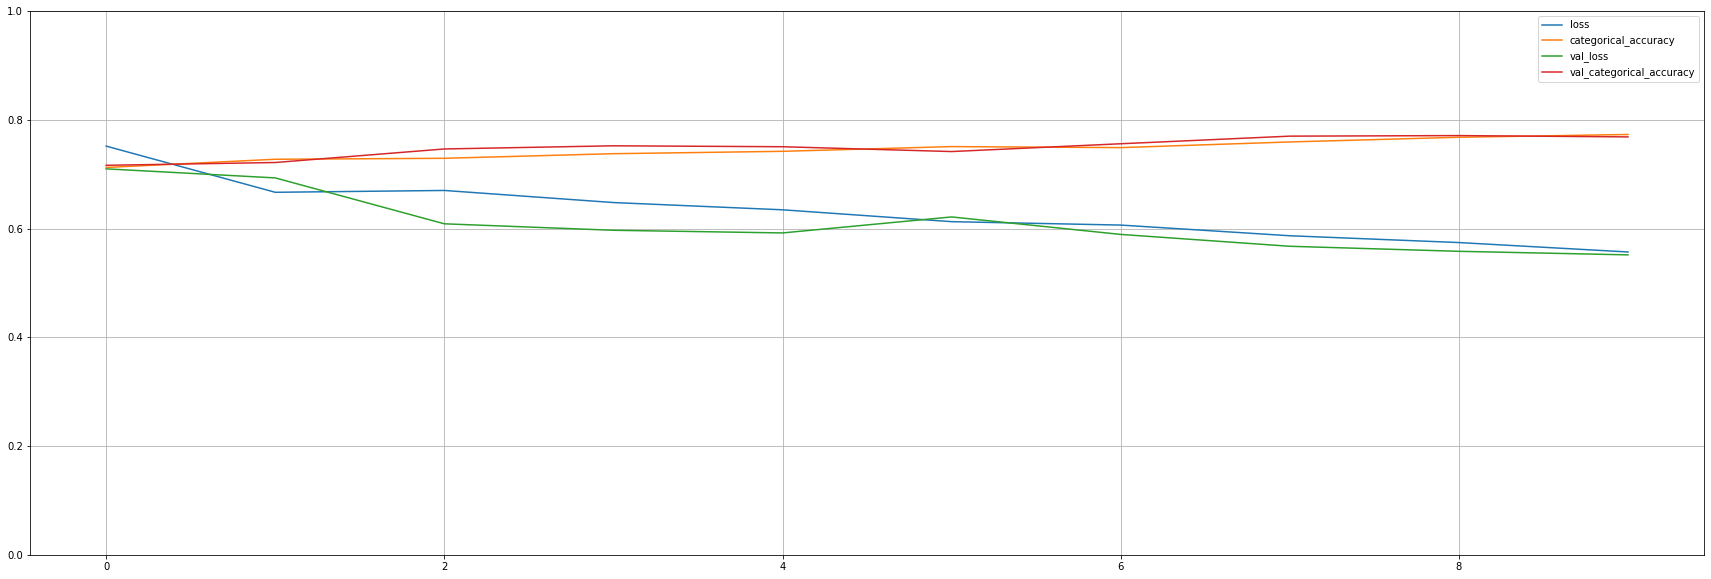

In [ ]:
pd.DataFrame(history.history).plot(figsize=(30,10))
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
model_saved=tf.keras.models.load_model(model_save_v3,compile=False)

In [ ]:
model_saved.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [ ]:
output=model_saved.predict(['day dream'])
if np.argmax(output)==2:
  print('Positive')
elif np.argmax(output):
  print('Neutral')
else:
  print('Negetive')

1/1 [==============================] - 0s 91ms/step
Neutral


In [ ]:
serving_results = model_saved.signatures['serving_default'](tf.constant(['sad day']))
output=np.argmax(serving_results['classifier'])
if output==2:
  print('Positive')
elif output:
  print('Neutral')
else:
  print('Negetive')

Neutral
